## Importing Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import csv
import matplotlib.cm as cm
import time
import math
from lazypredict.Supervised import LazyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from warnings import filterwarnings
filterwarnings(action='ignore')
random_seed = int(time.time())

## Loading Dataset

In [10]:
path = kagglehub.dataset_download("bhavikbb/password-strength-classifier-dataset")
csv_file = os.path.join(path, 'data.csv')

passwords = []
strengths = []

with open(csv_file, 'r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    for row in csv_reader:
        if len(row) == 2:
            passwords.append(row[0])
            strengths.append(int(row[1]))

df = pd.DataFrame({'password': passwords, 'strength': strengths})
df = df.sample(n=10000, random_state=random_seed) #We chose 10k samples so we can compute each model in reasonable time.

print(df.head())
print(df.shape)

                password  strength
300541            hh66ff         0
109571  DpJXBiDc0Mwwlu5H         2
110627         napalm313         1
126269        julios2bia         1
503850  5mTk3ZjA2NgbxMqd         2
(10000, 2)


## Description

In [11]:
print(df.describe(include='all'))

       password  strength
count     10000  10000.00
unique    10000       NaN
top      hh66ff       NaN
freq          1       NaN
mean        NaN      0.98
std         NaN      0.51
min         NaN      0.00
25%         NaN      1.00
50%         NaN      1.00
75%         NaN      1.00
max         NaN      2.00


## Finding Null Values

In [12]:
print(df.isna().sum())

password    0
strength    0
dtype: int64


## Feature Engineering

In [13]:
def calculate_entropy(password):
    if not password:
        return 0
    counts = Counter(password)
    total_length = len(password)
    entropy = -sum((count / total_length) * math.log2(count / total_length) for count in counts.values())
    return entropy

def calculate_diversity(password):
    lower = sum(1 for c in password if c.islower())
    upper = sum(1 for c in password if c.isupper())
    digits = sum(1 for c in password if c.isdigit())
    specials = sum(1 for c in password if not c.isalnum())
    return lower, upper, digits, specials

def contains_sequential(password):
    for seq in ["secret", "abc", "qwe", "asd", "zxc", "123", "456", "789", "pass", "111", "222", "333", "444", "555", "666", "777", "888", "999"]:
        if seq in password.lower():
            return 1
    return 0


def calculate_length(password):
    return len(password)

# Apply feature engineering functions to the dataset
df['length'] = df['password'].apply(calculate_length)
df['entropy'] = df['password'].apply(calculate_entropy)
df['lowercase'], df['uppercase'], df['digits'], df['specials'] = zip(*df['password'].apply(calculate_diversity))
df['sequential'] = df['password'].apply(contains_sequential)

# New dataframe including the new features
print(df.head(10))

                password  strength  length  entropy  lowercase  uppercase  \
300541            hh66ff         0       6     1.58          4          0   
109571  DpJXBiDc0Mwwlu5H         2      16     3.75          7          7   
110627         napalm313         1       9     2.73          6          0   
126269        julios2bia         1      10     3.12          9          0   
503850  5mTk3ZjA2NgbxMqd         2      16     4.00          8          5   
318255           azv6ub8         0       7     2.81          5          0   
407636       q6553565535         1      11     1.69          1          0   
263884       fiyruzaq542         1      11     3.46          8          0   
477672          zx95wk14         1       8     3.00          4          0   
342111    mortgages1977S         2      14     3.52          9          1   

        digits  specials  sequential  
300541       2         0           0  
109571       2         0           0  
110627       3         0           

## Data Analysis

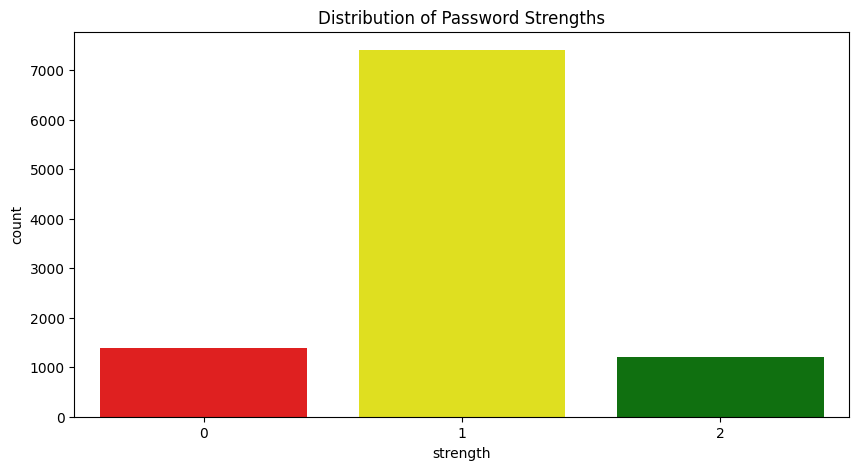

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='strength', data=df, palette={"0":"red", "1" :"yellow", "2": "green"})
plt.title('Distribution of Password Strengths')
plt.show()

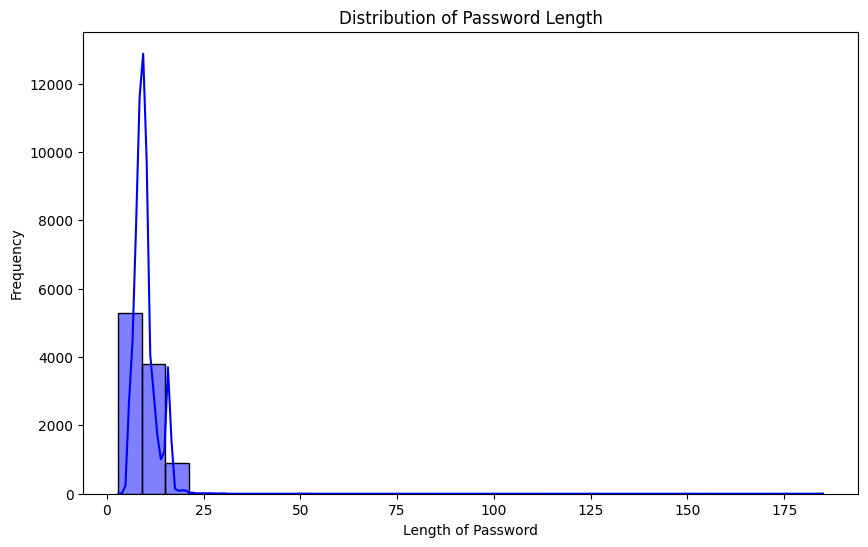

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Password Length')
plt.xlabel('Length of Password')
plt.ylabel('Frequency')
plt.show()

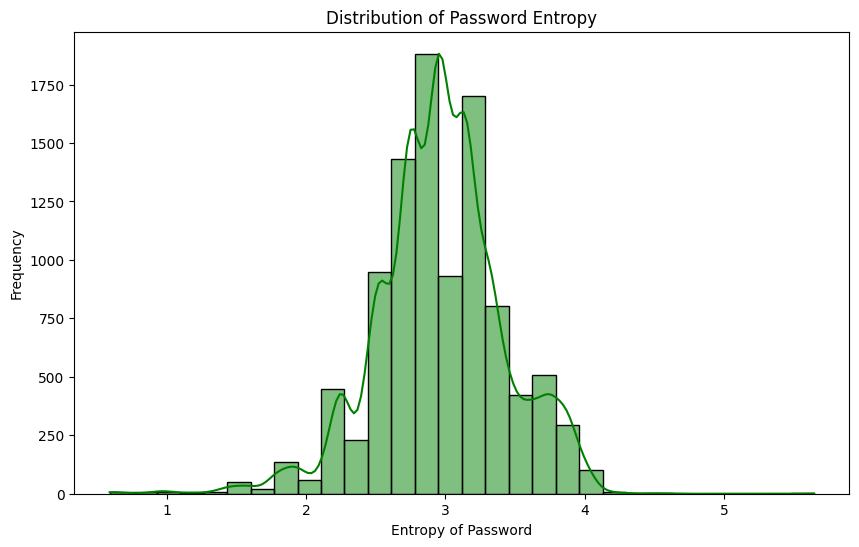

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['entropy'], bins=30, kde=True, color='green')
plt.title('Distribution of Password Entropy')
plt.xlabel('Entropy of Password')
plt.ylabel('Frequency')
plt.show()

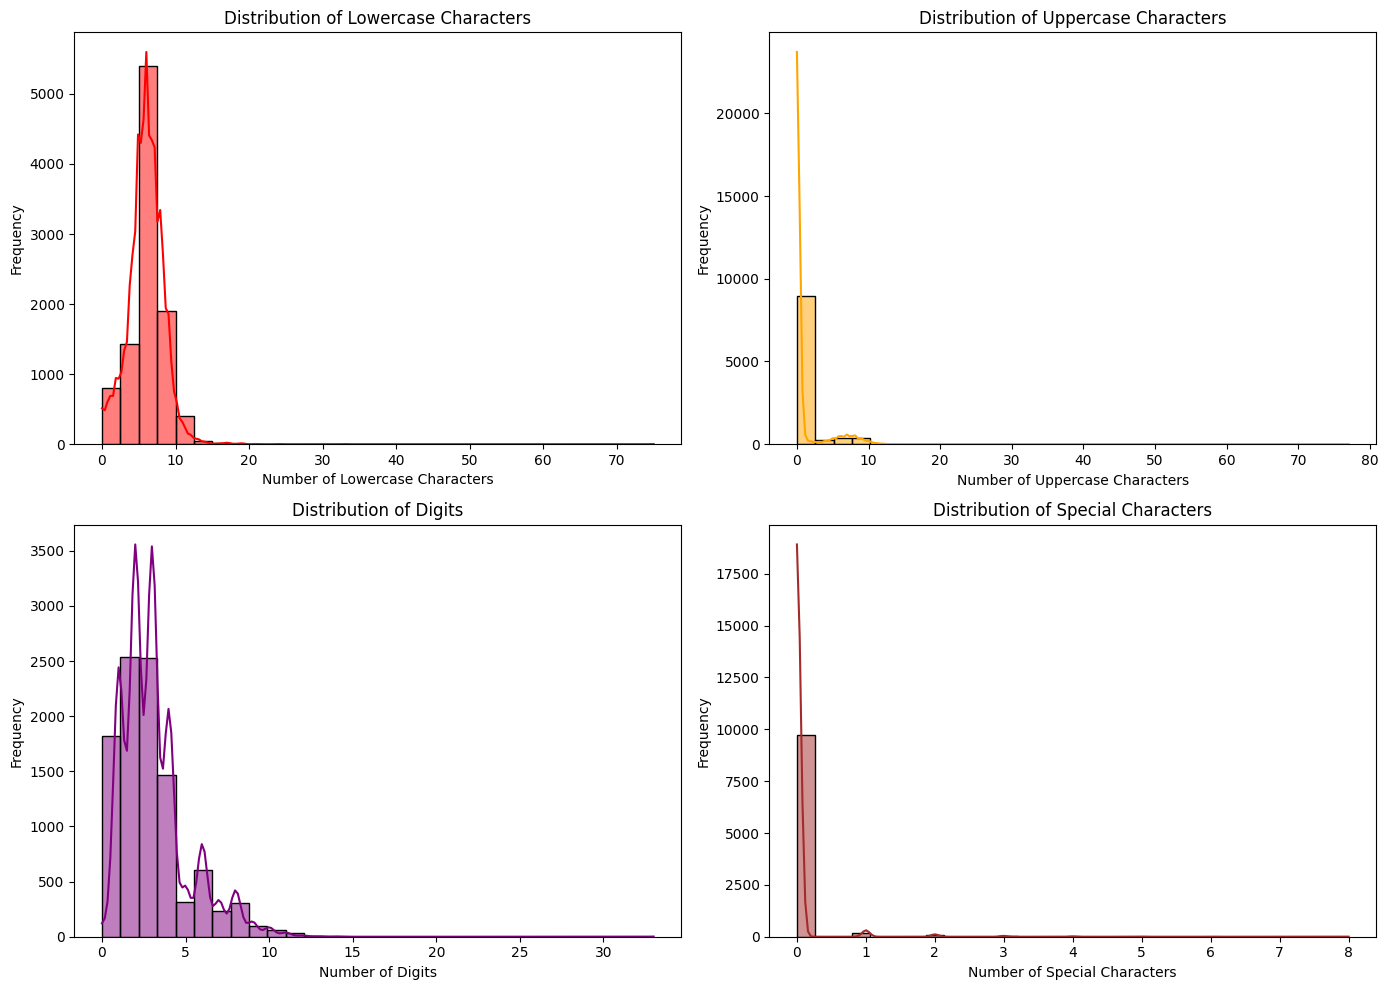

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Lowercase characters
sns.histplot(df['lowercase'], bins=30, kde=True, color='red', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Lowercase Characters')
axes[0, 0].set_xlabel('Number of Lowercase Characters')
axes[0, 0].set_ylabel('Frequency')

# Uppercase characters
sns.histplot(df['uppercase'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Uppercase Characters')
axes[0, 1].set_xlabel('Number of Uppercase Characters')
axes[0, 1].set_ylabel('Frequency')

# Digits
sns.histplot(df['digits'], bins=30, kde=True, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Digits')
axes[1, 0].set_xlabel('Number of Digits')
axes[1, 0].set_ylabel('Frequency')

# Specials
sns.histplot(df['specials'], bins=30, kde=True, color='brown', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Special Characters')
axes[1, 1].set_xlabel('Number of Special Characters')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

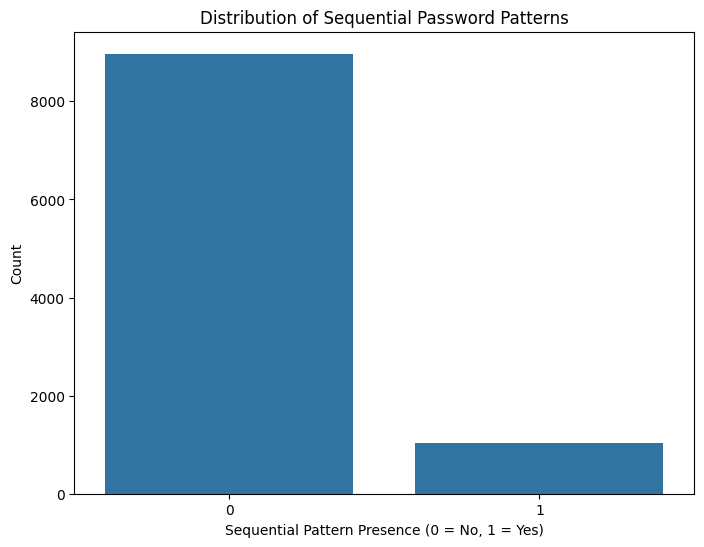

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['sequential'])
plt.title('Distribution of Sequential Password Patterns')
plt.xlabel('Sequential Pattern Presence (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

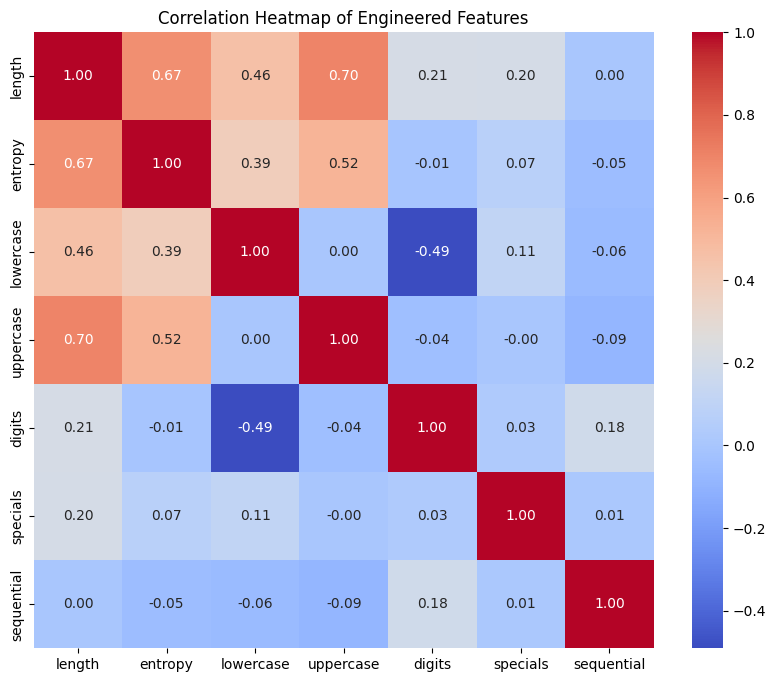

In [19]:
plt.figure(figsize=(10, 8))
corr = df[['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

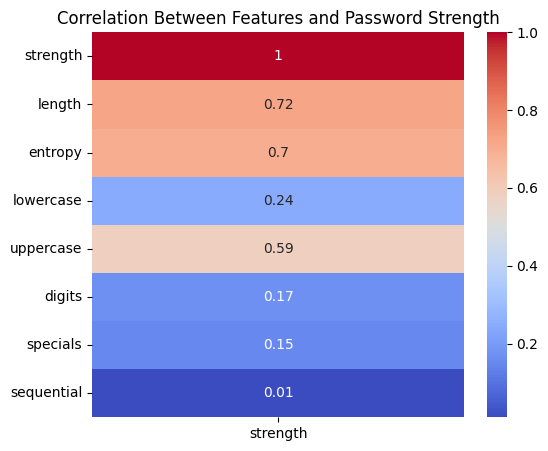

In [20]:
# Correlation Between Features and Password Strength
corr = df.corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr[['strength']], annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Password Strength')
plt.show()

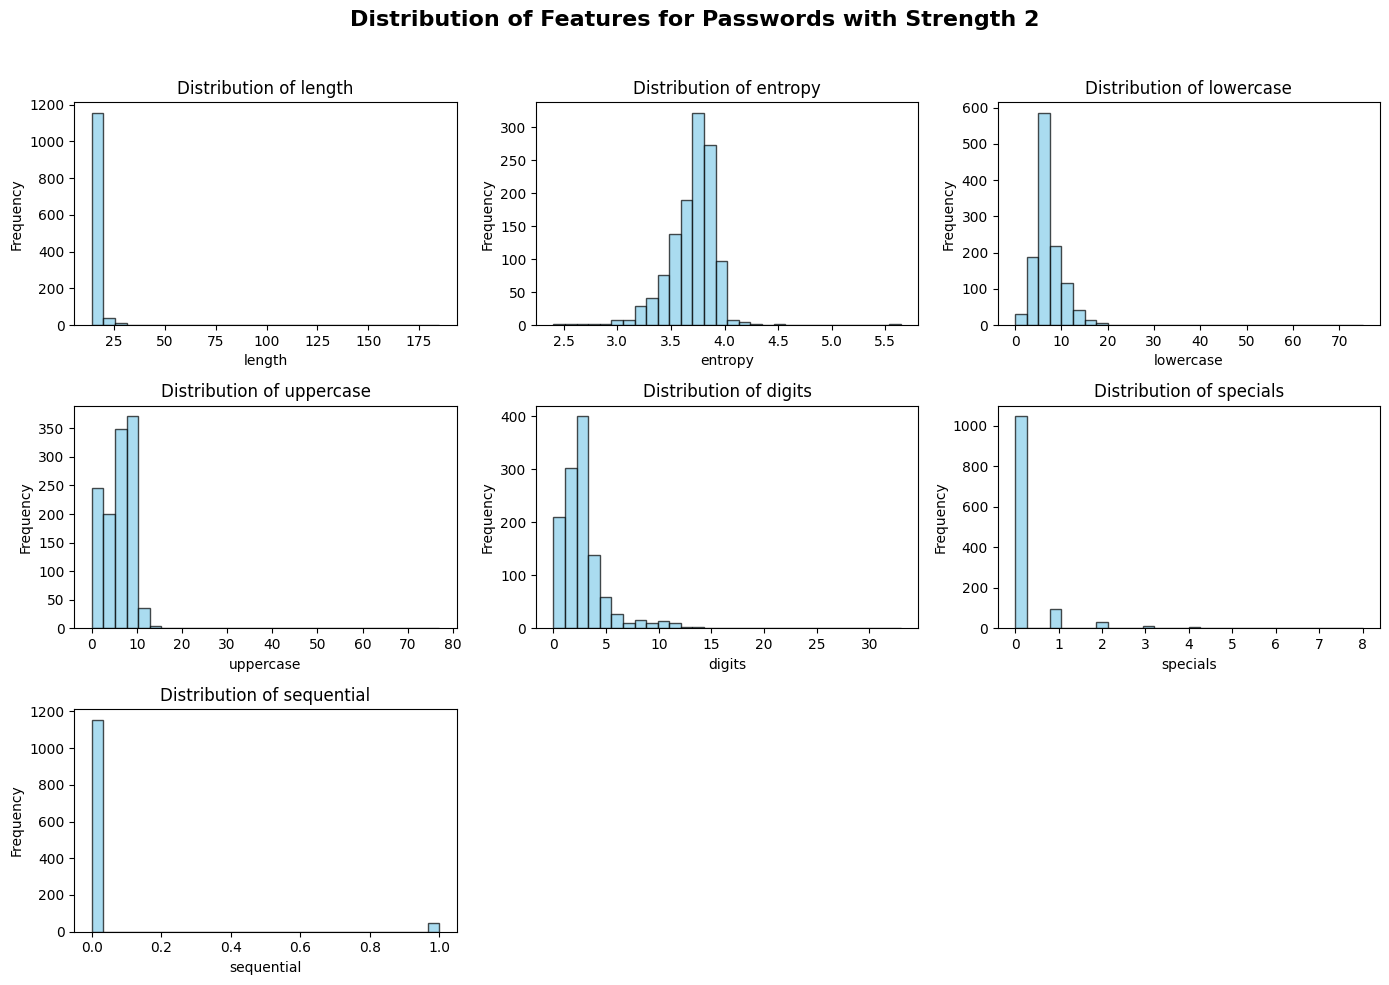

In [21]:
# Filter the dataset for passwords with strength "2"
df_strength_2 = df[df['strength'] == 2]

# List of features to visualize
features = ['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']

# Create histograms to show the distribution of each feature for passwords with strength "2"
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots
    df_strength_2[feature].plot(kind='hist', bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Add a large title for all the subplots
plt.suptitle('Distribution of Features for Passwords with Strength 2', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()

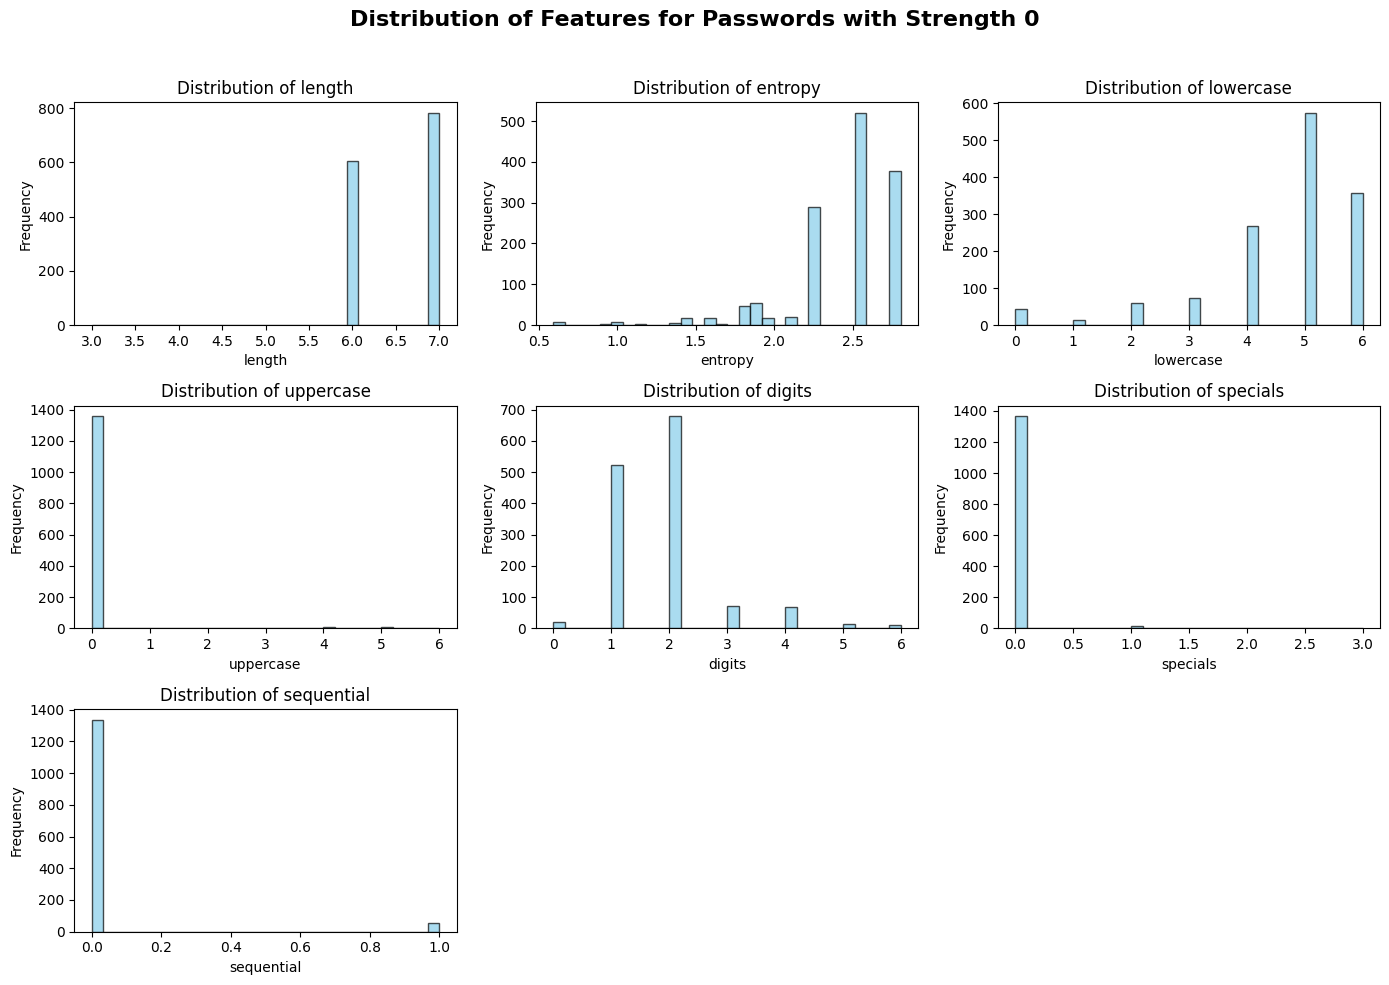

In [22]:
# Filter the dataset for passwords with strength "0"
df_strength_0 = df[df['strength'] == 0]

# Create histograms to show the distribution of each feature for passwords with strength "0"
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots
    df_strength_0[feature].plot(kind='hist', bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Add a large title for all the subplots
plt.suptitle('Distribution of Features for Passwords with Strength 0', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()


## Prepare the engineered features

In [24]:
X_engineered = df[['length','entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']]
X_engineered_nl = df[['entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']]
y = df['strength']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.3, random_state=random_seed,shuffle=True)
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_engineered_nl, y, test_size=0.3, random_state=random_seed,shuffle=True)

## Model Training

In [ ]:
# Initialize and train LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)


In [ ]:
# We train an additional individual Random Forest and Decision Tree models to show feature importance
print("\nRandom Forest Classifier:")
rf_model = RandomForestClassifier(random_state=random_seed)
rf_model.fit(X_train, y_train)

In [ ]:
print("\nDecision Tree Classifier:")
dt_model = DecisionTreeClassifier(random_state=random_seed)
dt_model.fit(X_train, y_train)

In [ ]:
print("\nDecision Tree Classifier (without 'length'):")
dt_model_nl = DecisionTreeClassifier(random_state=random_seed)
dt_model_nl.fit(X_train_nl, y_train_nl)

## Model Comparison

In [34]:
# Display the model performance
print("\nModel Comparison:")
models


Model Comparison:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,None,1.00,0.11
BaggingClassifier,1.00,1.00,None,1.00,0.02
XGBClassifier,1.00,1.00,None,1.00,0.12
RandomForestClassifier,1.00,1.00,None,1.00,0.13
LGBMClassifier,1.00,1.00,None,1.00,0.30
DecisionTreeClassifier,1.00,1.00,None,1.00,0.01
ExtraTreesClassifier,1.00,1.00,None,1.00,0.14
LogisticRegression,1.00,1.00,None,1.00,0.02
ExtraTreeClassifier,1.00,1.00,None,1.00,0.01


#### We choose DecisionTreeClassifier since it is the fastest and provides an accuracy of 100%. (We checked that this is not overfitting)

## Feature Importance

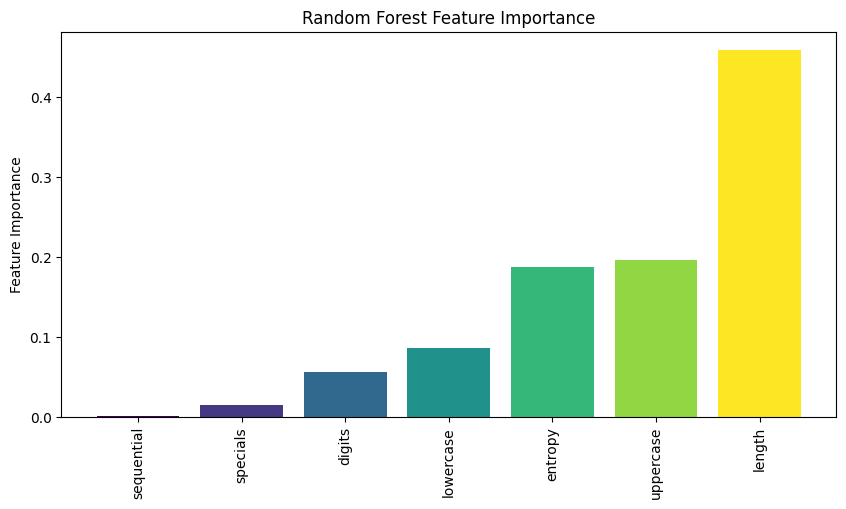

In [35]:
# Get the feature importances and sort them
rf_importances = rf_model.feature_importances_
features = X_engineered.columns
sorted_indices = np.argsort(rf_importances)[::-1]  # Sort in descending order

# Sort features and their importances
sorted_features = np.array(features)[sorted_indices]
sorted_importances = rf_importances[sorted_indices]

# Create a colormap for the bars
colors = cm.viridis(np.linspace(0, 1, len(sorted_importances)))

# Plot the sorted feature importances, with the graph standing up
plt.figure(figsize=(10, 5))
plt.bar(sorted_features[::-1], sorted_importances[::-1], color=colors)
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

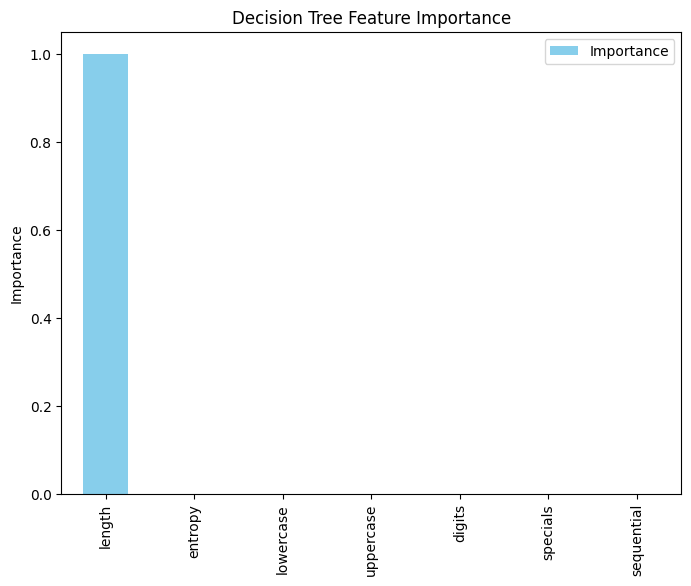

In [36]:
# Get the feature importances from the Decision Tree model
feat_importances = pd.DataFrame(dt_model.feature_importances_, index=X_engineered.columns, columns=["Importance"])

# Sort the feature importances in descending order
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances as a bar chart
feat_importances.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Decision Tree Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

#### We can see that length dominates the other features. What if we did not use it?

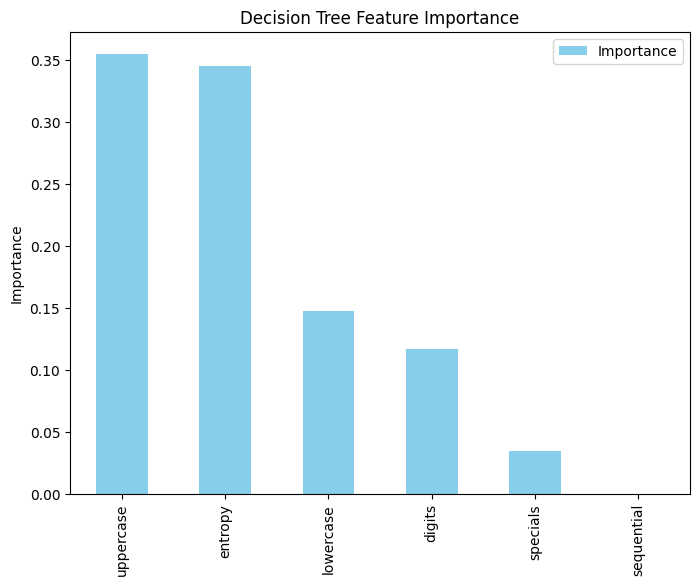

In [37]:
# Get the feature importances from the Decision Tree model without the 'length' feature.
feat_importances = pd.DataFrame(dt_model_nl.feature_importances_, index=X_engineered_nl.columns, columns=["Importance"])

# Sort the feature importances in descending order
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances as a bar chart
feat_importances.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Decision Tree Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

#### Feature Importance for Passwords Classified as "strong"

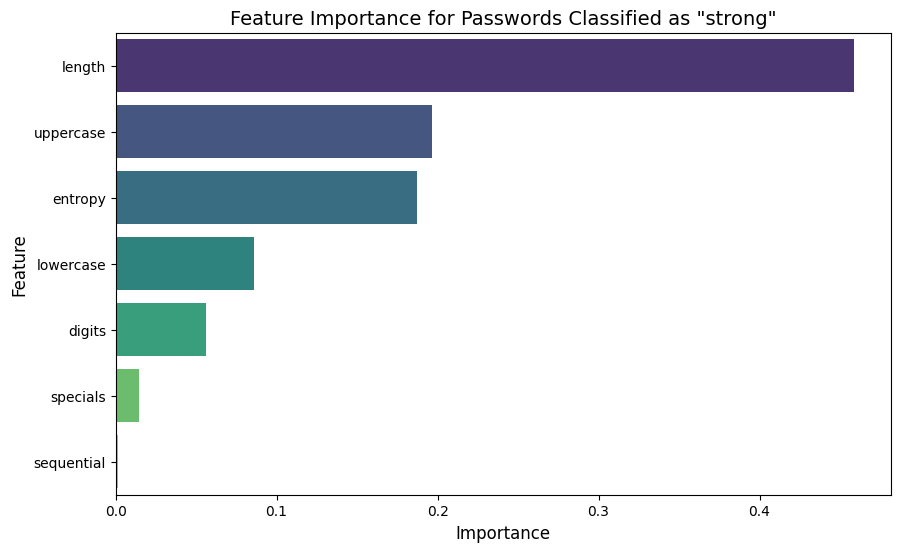

In [38]:
# Filter the data to get the passwords classified as 2
X_class_2 = X_train[y_train == 2]

# Get the feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization of features and their importance
importance_df = pd.DataFrame({
    'Feature': X_class_2.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Set plot labels and title
plt.title('Feature Importance for Passwords Classified as "strong"', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Show the plot
plt.show()

#### We can derive from this graph that 'length', 'uppercase' and 'entropy' are the most important features to a password 